In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\envs\book-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({'font.size': 14})

## Zero-shot forecasting with Moirai

In [3]:
df = pd.read_csv('../data/walmart_sales_small.csv', parse_dates=['Date'])

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df = df[['Store', 'Date', 'Weekly_Sales']]
df = df.set_index('Date')
df.head()

,Store,Weekly_Sales
Date,,
2010-02-05,1,1643690.90
2010-02-12,1,1641957.44
2010-02-19,1,1611968.17
2010-02-26,1,1409727.59
2010-03-05,1,1554806.68


In [5]:
ds = PandasDataset.from_long_dataframe(df, target='Weekly_Sales', item_id='Store')

In [6]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small"),
    prediction_length=8,
    context_length=len(df.query('Store == 1')),
    patch_size='auto',
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real
)

In [7]:
predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(ds)
forecasts = list(forecasts)

In [8]:
def get_median_and_ci(data, 
                      start_date,
                      horizon,
                      freq,
                      id,
                      confidence=0.95):

    n_samples, n_timesteps = data.shape
    
    # Calculate the median for each timestep
    medians = np.median(data, axis=0)
    
    # Calculate the lower and upper percentile for the given confidence interval
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    
    # Calculate the lower and upper bounds for each timestep
    lower_bounds = np.percentile(data, lower_percentile, axis=0)
    upper_bounds = np.percentile(data, upper_percentile, axis=0)

    pred_dates = pd.date_range(start=start_date, periods=horizon, freq=freq)
    formatted_dates = pred_dates.strftime('%m-%d-%Y').tolist()
    
    # Create a DataFrame with the results
    df = pd.DataFrame({
        'Date': formatted_dates,
        'Store': id,
        'Moirai': medians,
        f'Moirai-lo-{int(confidence*100)}': lower_bounds,
        f'Moirai-hi-{int(confidence*100)}': upper_bounds
    })
    
    return df

In [9]:
preds = [
    get_median_and_ci(
        data=forecasts[i].samples,
        start_date='11-02-2012',
        horizon=8,
        freq='W-FRI',
        id=i+1
    )
    for i in range(4)
]

preds_df = pd.concat(preds, axis=0, ignore_index=True)
preds_df['Date'] = pd.to_datetime(preds_df['Date'])

preds_df

,Date,Store,Moirai,Moirai-lo-95,Moirai-hi-95
0,2012-11-02,1,1.548185e+06,1.313200e+06,1.758678e+06
1,2012-11-09,1,1.526617e+06,1.273343e+06,1.708843e+06
2,2012-11-16,1,1.540036e+06,1.177155e+06,1.795635e+06
3,2012-11-23,1,1.531388e+06,1.300719e+06,1.733393e+06
4,2012-11-30,1,1.540447e+06,1.370690e+06,1.880624e+06
5,2012-12-07,1,1.531060e+06,1.237418e+06,1.761044e+06
6,2012-12-14,1,1.539679e+06,1.272562e+06,1.791842e+06
7,2012-12-21,1,1.519700e+06,1.254338e+06,1.832807e+06
8,2012-11-02,2,1.864918e+06,1.560657e+06,2.318972e+06
9,2012-11-09,2,1.860380e+06,1.659979e+06,2.146143e+06


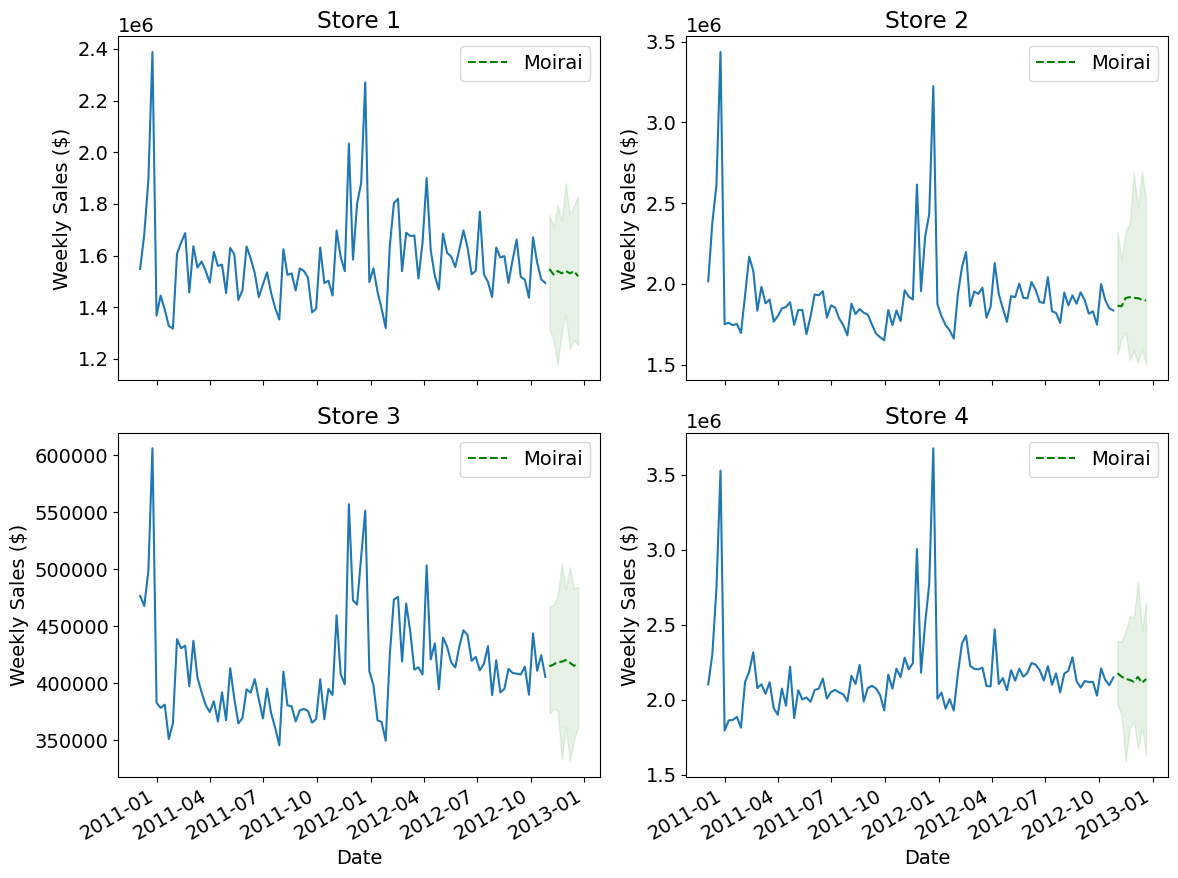

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

plot_df = df.reset_index(drop=False).copy()
plot_preds_df = preds_df.copy()

for i, ax in enumerate(axes.flatten()):
    df = plot_df[plot_df['Store'] == i+1].iloc[-100:]
    preds_df = plot_preds_df[plot_preds_df['Store'] == i+1]

    ax.plot(df['Date'], df['Weekly_Sales'])
    ax.plot(preds_df['Date'], preds_df['Moirai'], 'g--', label='Moirai')
    ax.fill_between(preds_df['Date'], preds_df['Moirai-lo-95'], preds_df['Moirai-hi-95'], alpha=0.1, color='green')
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH06_codefig01.png", dpi=300)

## Cross-validation with Moirai

In [11]:
df = pd.read_csv('../data/walmart_sales_small.csv', parse_dates=['Date'])
df = df.query("Store == 1")
df = df[['Store', 'Date', 'Weekly_Sales']]
df = df.set_index('Date')

df.head()

,Store,Weekly_Sales
Date,,
2010-02-05,1,1643690.90
2010-02-12,1,1641957.44
2010-02-19,1,1611968.17
2010-02-26,1,1409727.59
2010-03-05,1,1554806.68


In [12]:
ds = PandasDataset.from_long_dataframe(df, 
                                       target="Weekly_Sales", 
                                       item_id="Store")

In [13]:
train, test_template = split(ds, offset=-32)

test_data = test_template.generate_instances(
    prediction_length=8,
    windows=4,
    distance=8
)

In [14]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=8,
    context_length=100,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(test_data.input)

In [15]:
forecasts = list(forecasts)

In [16]:
start_dates = ["2012-03-23", "2012-05-18", "2012-07-13", "2012-09-07"]

cv_preds = [
    get_median_and_ci(
        data=forecasts[i].samples,
        start_date=start_dates[i],
        horizon=8,
        freq='W-FRI',
        id=1
    )
    for i in range(4)
]

cv_preds_df = pd.concat(cv_preds, axis=0, ignore_index=True)
cv_preds_df['Date'] = pd.to_datetime(cv_preds_df['Date'])

cv_preds_df

,Date,Store,Moirai,Moirai-lo-95,Moirai-hi-95
0,2012-03-23,1,1639540.750,1.449165e+06,2.317609e+06
1,2012-03-30,1,1618520.500,1.439972e+06,2.948981e+06
2,2012-04-06,1,1613454.000,1.301450e+06,2.869518e+06
3,2012-04-13,1,1571041.500,1.336210e+06,2.610634e+06
4,2012-04-20,1,1597585.750,1.307176e+06,2.189555e+06
5,2012-04-27,1,1592660.625,1.358492e+06,2.519021e+06
6,2012-05-04,1,1645042.500,1.336776e+06,2.885410e+06
7,2012-05-11,1,1637671.125,1.333490e+06,2.569951e+06
8,2012-05-18,1,1589541.375,1.431234e+06,1.943412e+06
9,2012-05-25,1,1591734.000,1.386711e+06,2.136450e+06


In [17]:
cv_preds_df['Weekly_Sales'] = df.iloc[-32:]['Weekly_Sales'].values
cv_preds_df

,Date,Store,Moirai,Moirai-lo-95,Moirai-hi-95,Weekly_Sales
0,2012-03-23,1,1639540.750,1.449165e+06,2.317609e+06,1511068.07
1,2012-03-30,1,1618520.500,1.439972e+06,2.948981e+06,1649604.63
2,2012-04-06,1,1613454.000,1.301450e+06,2.869518e+06,1899676.88
3,2012-04-13,1,1571041.500,1.336210e+06,2.610634e+06,1621031.70
4,2012-04-20,1,1597585.750,1.307176e+06,2.189555e+06,1521577.87
5,2012-04-27,1,1592660.625,1.358492e+06,2.519021e+06,1468928.37
6,2012-05-04,1,1645042.500,1.336776e+06,2.885410e+06,1684519.99
7,2012-05-11,1,1637671.125,1.333490e+06,2.569951e+06,1611096.05
8,2012-05-18,1,1589541.375,1.431234e+06,1.943412e+06,1595901.87
9,2012-05-25,1,1591734.000,1.386711e+06,2.136450e+06,1555444.55


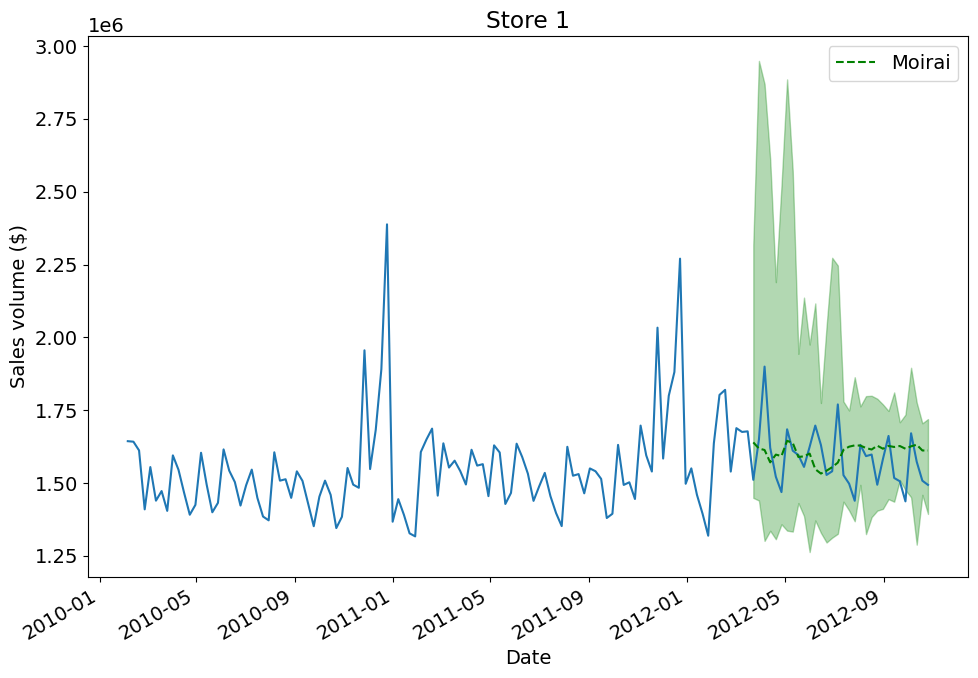

In [18]:
fig, ax = plt.subplots(figsize=(10,7))

plot_df = df.reset_index(drop=False).copy()

ax.plot(plot_df['Date'], plot_df['Weekly_Sales'])
ax.plot(cv_preds_df['Date'], cv_preds_df['Moirai'], ls='--', color='green', label='Moirai')
ax.fill_between(cv_preds_df['Date'], cv_preds_df['Moirai-lo-95'], cv_preds_df['Moirai-hi-95'], color="green", alpha=0.3)

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH06_codefig02.png", dpi=300)

In [19]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

evaluation = evaluate(
    cv_preds_df,
    metrics=[mae, smape],
    models=['Moirai'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,Moirai
0,1,mae,84139.779844
1,1,smape,0.026362


## Forecasting with features

In [20]:
df = pd.read_csv('../data/walmart_sales_small.csv', parse_dates=['Date'])
df = df.query("Store == 1")
df = df.set_index('Date')

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [21]:
ds = PandasDataset.from_long_dataframe(
    df,
    target='Weekly_Sales',
    item_id='Store',
    past_feat_dynamic_real=["Temperature", "Fuel_Price", "CPI", "Unemployment"],
    feat_dynamic_real=["Holiday_Flag"]
)

In [22]:
train, test_template = split(
    ds, offset=-32
)

test_data = test_template.generate_instances(
    prediction_length=8,
    windows=4,
    distance=8
)

In [23]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=8,
    context_length=100,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(test_data.input)
forecasts = list(forecasts)

In [24]:
start_dates = ["2012-03-23", "2012-05-18", "2012-07-13", "2012-09-07"]

cv_feat_preds = [
    get_median_and_ci(
        data=forecasts[i].samples,
        start_date=start_dates[i],
        horizon=8,
        freq='W-FRI',
        id=1
    )
    for i in range(4)
]

cv_feat_preds_df = pd.concat(cv_feat_preds, axis=0, ignore_index=True)
cv_feat_preds_df['Date'] = pd.to_datetime(cv_feat_preds_df['Date'])

cv_feat_preds_df['Weekly_Sales'] = df.iloc[-32:]['Weekly_Sales'].values
cv_feat_preds_df

,Date,Store,Moirai,Moirai-lo-95,Moirai-hi-95,Weekly_Sales
0,2012-03-23,1,1667054.250,1.381387e+06,2.246749e+06,1511068.07
1,2012-03-30,1,1646865.375,1.335945e+06,2.496309e+06,1649604.63
2,2012-04-06,1,1650913.875,1.376583e+06,2.629663e+06,1899676.88
3,2012-04-13,1,1636693.875,1.262196e+06,2.316733e+06,1621031.70
4,2012-04-20,1,1600430.250,1.320150e+06,2.365793e+06,1521577.87
5,2012-04-27,1,1690866.250,1.329612e+06,2.808617e+06,1468928.37
6,2012-05-04,1,1697833.250,1.143209e+06,2.592870e+06,1684519.99
7,2012-05-11,1,1670146.375,1.106895e+06,2.763325e+06,1611096.05
8,2012-05-18,1,1592798.500,1.396305e+06,1.722421e+06,1595901.87
9,2012-05-25,1,1607876.875,1.460475e+06,1.884908e+06,1555444.55


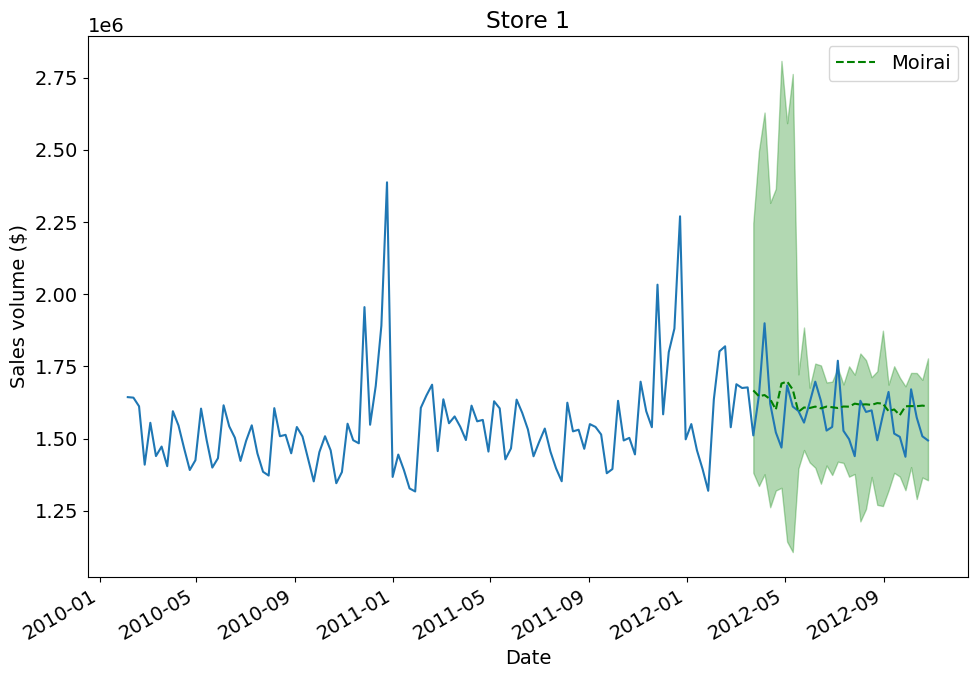

In [25]:
fig, ax = plt.subplots(figsize=(10,7))

plot_df = df.reset_index(drop=False).copy()

ax.plot(plot_df['Date'], plot_df['Weekly_Sales'])
ax.plot(cv_feat_preds_df['Date'], cv_feat_preds_df['Moirai'], ls='--', color='green', label='Moirai')
ax.fill_between(cv_feat_preds_df['Date'], cv_feat_preds_df['Moirai-lo-95'], cv_feat_preds_df['Moirai-hi-95'], color="green", alpha=0.3)

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH06_codefig03.png", dpi=300)

In [26]:
evaluation = evaluate(
    cv_feat_preds_df,
    metrics=[mae, smape],
    models=['Moirai'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,Moirai
0,1,mae,82040.826562
1,1,smape,0.025676


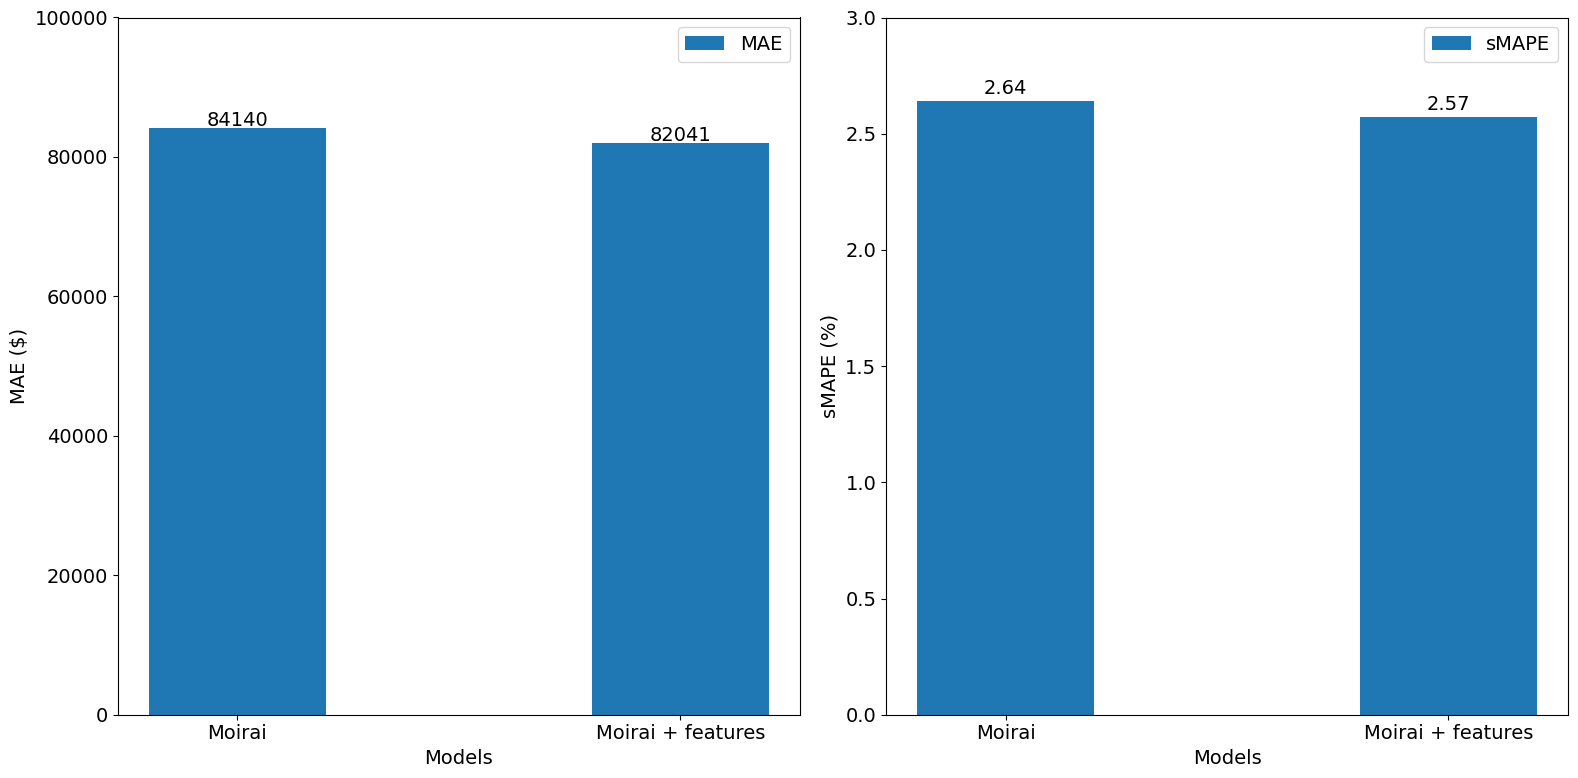

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['Moirai', 'Moirai + features']
y_mae = [84140, 82041]
y_smape = [2.64, 2.57]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.set_ylim(0, 100000)
ax1.legend()

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+300, s=str(v), ha='center')

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.set_ylim(0, 3)
ax2.legend()


for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center')

plt.tight_layout()
plt.savefig("figures/CH06_codefig04.png", dpi=300)

## Anomaly detection

In [28]:
df = pd.read_csv('../data/nyc_taxi_anomaly_daily.csv', parse_dates=['timestamp'])
df.head()

,timestamp,value,is_anomaly
0,2014-07-01,745967,0
1,2014-07-02,733640,0
2,2014-07-03,710142,0
3,2014-07-04,552565,0
4,2014-07-05,555470,0


In [29]:
def anomaly_detection_moirai(df, 
                             target_col, 
                             id_col,
                             date_col,
                             h, 
                             n_windows,
                             freq,
                             confidence=0.99):

    ds = PandasDataset.from_long_dataframe(
        df,
        target=target_col,
        item_id=id_col,
    )
    
    train, test_template = split(
    ds, offset=-(n_windows*h)
    )
    
    test_data = test_template.generate_instances(
        prediction_length=h,
        windows=n_windows,
        distance=h
    )

    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
        prediction_length=h,
        context_length=100,
        patch_size="auto",
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
    
    predictor = model.create_predictor(batch_size=32)
    forecasts = predictor.predict(test_data.input)
    forecasts = list(forecasts)

    df_test = df[-(n_windows*h):]

    list_dates = df_test[date_col]
    start_dates = list(list_dates[::h])

    cv_preds = [
        get_median_and_ci(
            data=forecasts[i].samples,
            start_date=start_dates[i],
            horizon=h,
            freq=freq,
            id=0,
            confidence=confidence
        )
        for i in range(n_windows)
    ]

    cv_preds_df = pd.concat(cv_preds, axis=0, ignore_index=True)
    cv_preds_df['Date'] = pd.to_datetime(cv_preds_df['Date'])

    df_test.rename(columns={date_col: 'Date'}, inplace=True)
    df_test = pd.merge(df_test, cv_preds_df, on='Date')
    df_test['anomaly'] = ((df_test[target_col] < df_test['Moirai-lo-99']) | (df_test[target_col] > df_test['Moirai-hi-99'])).astype(int)

    df_test = df_test.drop('Store', axis=1)

    return df_test

In [30]:
df['unique_id'] = 0

anomaly_df = anomaly_detection_moirai(df,
                                      target_col="value",
                                      id_col="unique_id",
                                      date_col="timestamp",
                                      h=23, 
                                      n_windows=8, 
                                      freq='D', 
                                      confidence=0.99)
anomaly_df

,Date,value,is_anomaly,unique_id,Moirai,Moirai-lo-99,Moirai-hi-99,anomaly
0,2014-08-01,769160,0,0,719716.0625,605322.954375,1.095137e+06,0
1,2014-08-02,781616,0,0,722916.6250,599733.069375,1.115940e+06,0
2,2014-08-03,699449,0,0,725984.1250,622391.535000,1.226329e+06,0
3,2014-08-04,662215,0,0,721104.3750,631489.031563,1.676579e+06,0
4,2014-08-05,710728,0,0,722654.7500,635163.562813,1.622481e+06,0
...,...,...,...,...,...,...,...,...
179,2015-01-27,232058,1,0,773248.8125,364758.416250,9.542659e+05,1
180,2015-01-28,621483,0,0,782380.7500,474709.547031,1.040337e+06,0
181,2015-01-29,704935,0,0,781520.0625,468330.055938,1.002701e+06,0
182,2015-01-30,800478,0,0,787913.5000,520413.253437,1.148577e+06,0


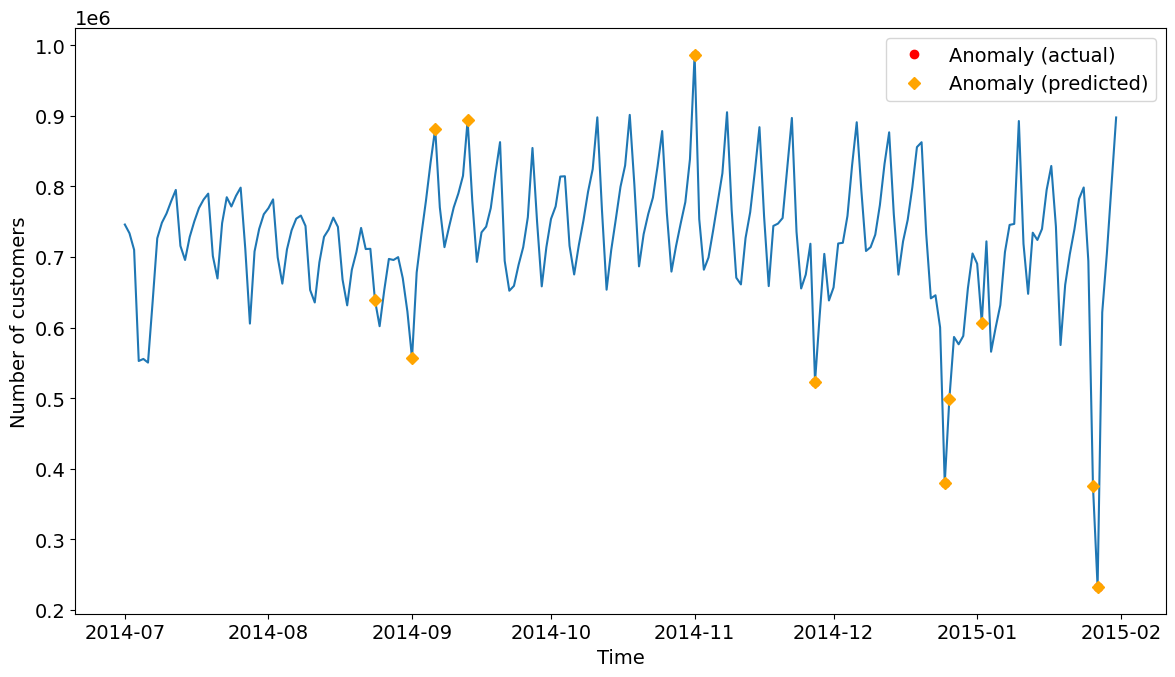

In [31]:
actual_anomaly_df = df.loc[df['is_anomaly'] == 1]
pred_anomaly_df = anomaly_df.loc[anomaly_df['anomaly'] == 1] 

fig, ax = plt.subplots(figsize=(12,7))

ax.plot(df['timestamp'], df['value'])
ax.plot(actual_anomaly_df['timestamp'], actual_anomaly_df['value'], 'o', color='red', label='Anomaly (actual)')
ax.plot(pred_anomaly_df['Date'], pred_anomaly_df['value'], 'D', color='orange', label='Anomaly (predicted)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(loc='best')

plt.tight_layout()
plt.savefig("figures/CH06_codefig05.png", dpi=300)

In [32]:
def evaluate_anomaly_detection(df, preds_col, actual_col):
    tp = ((df[preds_col] == 1) & (df[actual_col] == 1)).sum()
    
    tn = ((df[preds_col] == 0) & (df[actual_col] == 0)).sum()
    
    fp = ((df[preds_col] == 1) & (df[actual_col] == 0)).sum()
    
    fn = ((df[preds_col] == 0) & (df[actual_col] == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f1_score

In [33]:
precision, recall, f1_score = evaluate_anomaly_detection(anomaly_df[-182:], 'anomaly', 'is_anomaly')

print(f"Precision: {round(precision,2)}")
print(f"Recall: {round(recall,2)}")
print(f"F1-Score: {round(f1_score,2)}")

Precision: 0.36
Recall: 1.0
F1-Score: 0.53


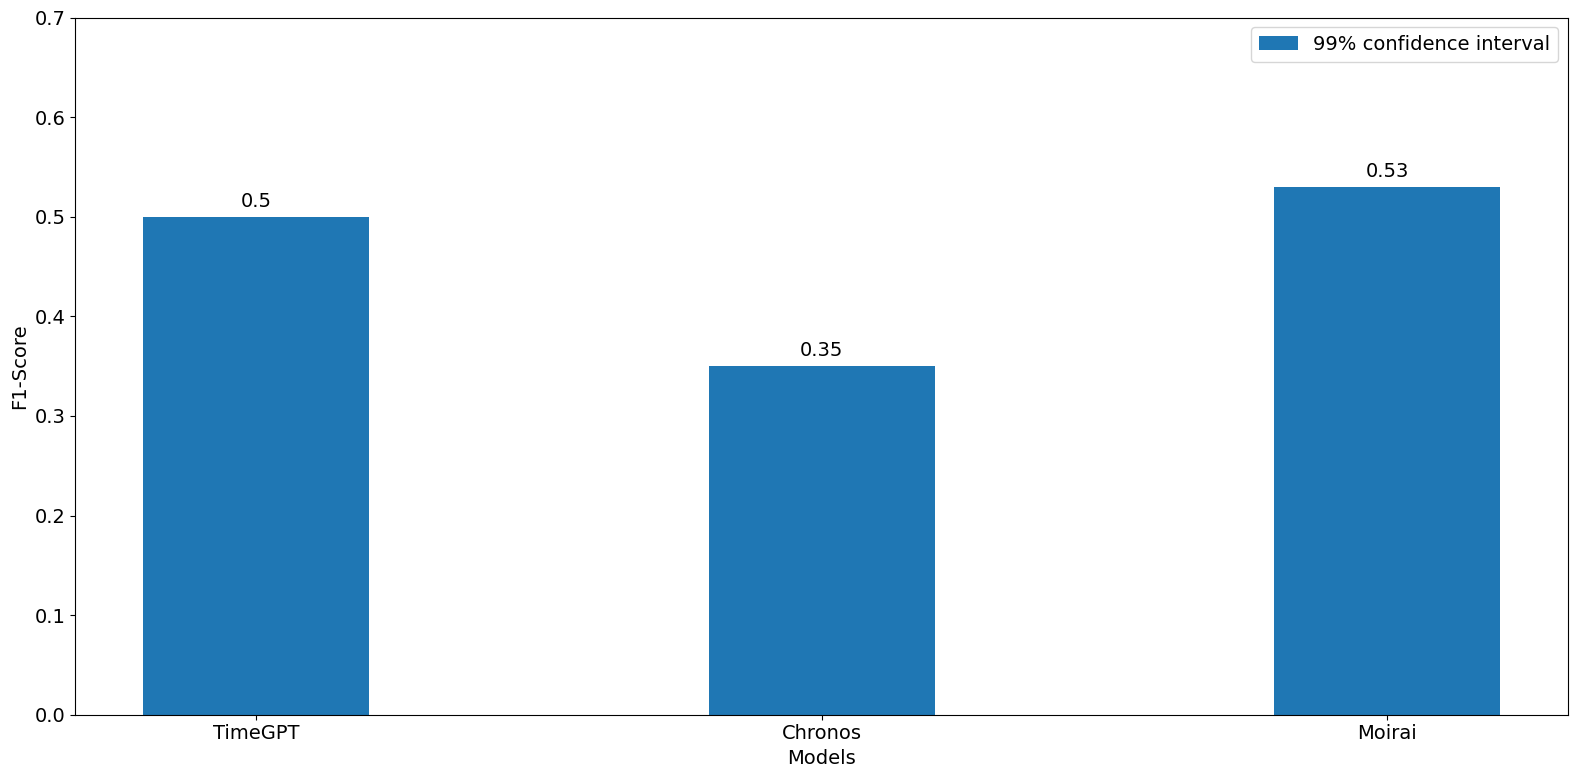

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

x = ['TimeGPT', 'Chronos', 'Moirai']
y = [0.50, 0.35, round(f1_score,2)]

ax.bar(x, y, width=0.4, label='99% confidence interval')
ax.set_xlabel('Models')
ax.set_ylabel('F1-Score')
ax.set_ylim(0,  0.7)
ax.legend()

for i, v in enumerate(y):
    ax.text(x=i, y=v+0.01, s=str(v), ha='center')

plt.tight_layout()
plt.savefig("figures/CH06_codefig06.png", dpi=300)